# Python speed comparison

Inevitably, an argument is made that python is slow.
This is mainly because it is an interpreted languague, unlike compiled languages such as C, C++, Fortran, or others.

While this is true, this is also not the whole picture as we will investigte in this notebook.
Here, we compare three different approaches: a "pure" python implementation, an optimised version, and just-in-time compilation.

As an example, we calculate the area of a circle with given radius using a Monte Carlo integration technique.

We will see that a pure python implementation is indeed rather slow. However, one would not follow such an approach but either use specialised libraries or use a special package called [Numba](https://numba.pydata.org/). The latter is a way to pre-compile parts of the code and then use this during execution. Other approaches such as [Cython](https://cython.org/) exist as well that can also optimise python code.
The advantage of this approach is that we can develop python code as we normally would - and then identify which parts would benefit from further optimisation. \
Compared to other languages, this has the benefit that we can make use of all benefits of python, and in particular, the increase in productivity when developing the code or application, and then optimise specific parts. Experience shows that only few functions would really benefit from such an optimisation, whereas most of the code is more concerned with the application infrastructure, user interaction, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# "compiled python"
import numba
from numba import jit

# profiler to measure execution speed in more detail
%load_ext line_profiler

## Monte Carlo integration

Before we start with looking at the speed of the various implementations, we first understand how we calculate the area of a circle. 
Of course, in this simple setup of a (two-dimensional) circle with radius $r$, we know that the area is given by $A = \pi \cdot r^2$ - however, in more complex scenarios, so such simple formula exists.

One approach is to use random points - this is called a Monte Carlo technique (named after the famous casino in the town with the same name).
Essentially, we "throw" random points on the plane and count how many of them land inside the circle compared to outside. The more points we use, the more accurate the estimate of the area of the circle will be.

In the implementation, we loop over the number of points we want to evaluate, obtain a uniform random number for the point $(x,y)$ and evaluate if the point is inside the circle or outside. The area given by the points inside and outside the circle is an estimate of the area of the circle.

The area of the circle is 12.54272, expected result 12.566370614359172, difference: 0.02365061435917326


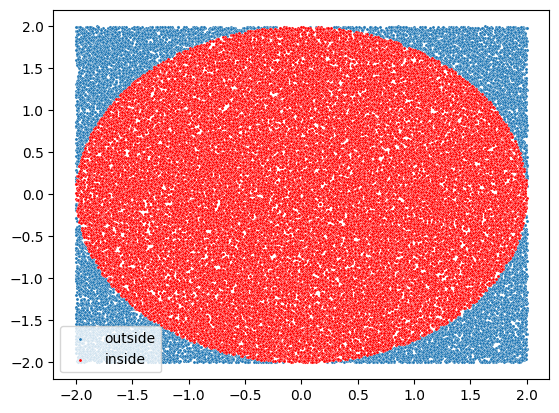

In [3]:
def area_circle(radius = 2, n_points = 500000):
    in_circle = 0
    x_points = []
    y_points = []
    x_points_circle = []
    y_points_circle = []

    for i in range(0, n_points):
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        if x**2 + y**2 < radius**2:
            in_circle += 1
            x_points_circle.append(x)
            y_points_circle.append(y)
        else:
            x_points.append(x)
            y_points.append(y)
    
    area = (2*radius)**2 * in_circle/n_points
    return x_points, y_points, x_points_circle, y_points_circle, area


radius = 2
x_points, y_points, x_points_circle, y_points_circle, area = area_circle(radius, 50000)
expected_area = np.pi*radius**2
print('The area of the circle is {}, expected result {}, difference: {}'.format(area, expected_area, np.abs(area - expected_area)))

sns.scatterplot(x=x_points, y=y_points, label='outside', s=5)
sns.scatterplot(x=x_points_circle, y=y_points_circle, color='red', label='inside', s=5)
plt.show()

### Native Implementation

Now we use the same code but strip all code that is not related to calculating the area to focus on the speed of the loop.


In [3]:
def area_circle(radius = 2, n_points = 500000):
    in_circle = 0

    for i in range(0, n_points):
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        if x**2 + y**2 < radius**2:
            in_circle += 1
    
    area = (2*radius)**2 * in_circle/n_points
    return area

In [36]:
%%time
n_points = 50000
radius = 2
area = area_circle(radius, n_points)
expected_area = np.pi*radius**2
print('The area of the circle is {}, expected result {}, difference: {}'.format(area, expected_area, np.abs(area - expected_area)))

The area of the circle is 12.53728, expected result 12.566370614359172, difference: 0.029090614359171596
CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms


We can run the ```line_profiler``` to get a more detailed view where the program spends most of the time.

In [4]:
lprun -f  area_circle area_circle()

Timer unit: 1e-09 s

Total time: 1.4412 s
File: /tmp/ipykernel_974/3957699394.py
Function: area_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def area_circle(radius = 2, n_points = 500000):
     2         1        997.0    997.0      0.0      in_circle = 0
     3                                           
     4    500000   54985724.0    110.0      3.8      for i in range(0, n_points):
     5    500000  587101233.0   1174.2     40.7          x = np.random.uniform(-radius, radius)
     6    500000  568074290.0   1136.1     39.4          y = np.random.uniform(-radius, radius)
     7    392630  171245431.0    436.1     11.9          if x**2 + y**2 < radius**2:
     8    392630   59790059.0    152.3      4.1              in_circle += 1
     9                                               
    10         1       1515.0   1515.0      0.0      area = (2*radius)**2 * in_circle/n_points
    11         1        6

As expected, most of the execution time is spent in the actual calculations, i.e. the generation of random numberss and the calculation whether or not the newly generated point falls within the circle.

The package "scalene" is a more powerful graphical profiler. We can use it as an example where we place the above code into a separate python program and then execute: ```scalene area.py```. This will then produce a web-page (profile.html by default) that will give us a detailed breakdown of where the program spends most of the time. It's a bit of an overkill for our example here but do try it out...

### Numpy optimisation

Next, we look at an optimised version using the Python package [NumPy](https://numpy.org/). 
In this case, numpy is well suited to our task, in other cases, we would use different optimised packages that are more appropriate for the respective task.

Instead of generating the random numbers one at a time, we let numpy generate arrays - this is much more efficient as the generation can be optimised "behind the scenes" in the numpy package.
Using an efficient filter, we can obtain all points inside the circle in one step, again exploiting the fact that this is highly optimised in the numpy package.

Comparing the run-time of both approaches, we see that the numpy version is faster by a factor of $\approx 50$.

In [33]:
def area_circle_numpy(radius = 2, n_points = 500000):

    x_points = np.random.uniform(-radius, radius, size=n_points) 
    y_points = np.random.uniform(-radius, radius, size=n_points) 
    radii = x_points*x_points + y_points*y_points

    in_circle = radii[radii < radius**2]

    area = (2*radius)**2 * len(in_circle)/n_points
    return area



In [37]:
%%time
area = area_circle_numpy(radius,n_points)
expected_area = np.pi*radius**2
print('The area of the circle is {}, expected result {}, difference: {}'.format(area, expected_area, np.abs(area - expected_area)))

The area of the circle is 12.59296, expected result 12.566370614359172, difference: 0.026589385640827246
CPU times: user 1.68 ms, sys: 1.22 ms, total: 2.9 ms
Wall time: 3.17 ms


###  Numba

The third approach uses the specialised package [Numba](https://numba.pydata.org/). This works by "passing" our code to a just-in-time compiler (JIT) that then optimises our code. Then, this optimised and compiled code is run instead of the interpreted code from the native python interpreter.

As we can see, this is again significantly faster than even the NumPy version above - although this varies from scenario to scenario.
Depending on how heavily Numba can optmise our code, we can achieve the same or similar performance compared to what we would expect from a C or C++ implementation. As a rule of thumb, numerical calculations can be optimised much better compared to user-interaction, input/output operations, etc.

Note that the only difference here compared to our python native implementation is the addition of the decorator ```@jit(nopython=True)```. This means we can use exactly the same code as before and improve the speed by a factor $\approx 100$ (in this case) by adding this one line. This means that we have all the benefits of writing python code without having to sacrifice performance.

N.B. The first time we execute this, Numba needs to compile the code. Hence, before we evaluate the performance, we need to run the code at least twice to measure the performance without the compilation step.

In [39]:
@jit(nopython=True)
def area_circle_numba(radius = 2, n_points = 500000):
    in_circle = 0

    for i in range(0, n_points):
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        if x**2 + y**2 < radius**2:
            in_circle += 1
    
    area = (2*radius)**2 * in_circle/n_points
    return area

In [43]:
%%time
area = area_circle_numba(radius,n_points)
expected_area = np.pi*radius**2
print('The area of the circle is {}, expected result {}, difference: {}'.format(area, expected_area, np.abs(area - expected_area)))

The area of the circle is 12.57696, expected result 12.566370614359172, difference: 0.010589385640827231
CPU times: user 285 µs, sys: 195 µs, total: 480 µs
Wall time: 487 µs
